In [ ]:
%matplotlib inline

## Validation Curves

Let us create an example dataset:

In [2]:
import numpy as np 
def generating_func(x, err=0.5):
    return np.random.normal(10 - 1. / (x + 0.1), err)

# randomly sample more data
np.random.seed(1)
x = np.random.random(size=200)
y = generating_func(x, err=1.)

Central to quantify bias and variance of a model is to apply it on test data, sampled from the same distribution as the train, but that will capture independent noise:

In [5]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.4)

Let's visualize the data:

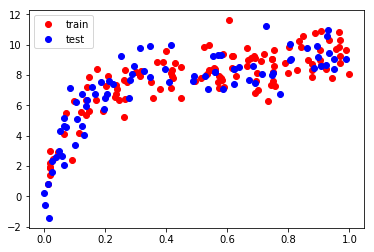

In [14]:
import matplotlib.pyplot as plt
plt.plot(xtrain,ytrain,'ro')
plt.plot(xtest,ytest,'bo')
plt.legend(['train','test'])

**Validation curve** A validation curve consists in varying a model parameter that controls its complexity (here the degree of the polynomial) and measures both error of the model on training data, and on test data (eg with cross-validation). The model parameter is then adjusted so that the test error is minimized:

We use `sklearn.model_selection.validation_curve()` to compute train and test error, and plot it:

/home/pbellec/env/nilearn/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


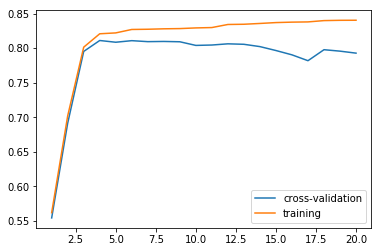

In [16]:
from sklearn.model_selection import validation_curve
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
degrees = np.arange(1, 21)

model = make_pipeline(PolynomialFeatures(), LinearRegression())

# Vary the "degrees" on the pipeline step "polynomialfeatures"
train_scores, validation_scores = validation_curve(
                model, x[:, np.newaxis], y,
                param_name='polynomialfeatures__degree',
                param_range=degrees)

# Plot the mean train score and validation score across folds
plt.plot(degrees, validation_scores.mean(axis=1), label='cross-validation')  

plt.plot(degrees, train_scores.mean(axis=1), label='training')  

plt.legend(loc='best') 

This figure shows why validation is important. On the left side of the plot, we have very low-degree polynomial, which under-fit the data. This leads to a low explained variance for both the training set and the validation set. On the far right side of the plot, we have a very high degree polynomial, which over-fits the data. This can be seen in the fact that the training explained variance is very high, while on the validation set, it is low. Choosing d around 4 or 5 gets us the best tradeoff. The astute reader will realize that something is amiss here: in the above plot, d = 4 gives the best results. But in the previous plot, we found that d = 6 vastly over-fits the data. What’s going on here? The difference is the number of training points used. In the previous example, there were only eight training points. In this example, we have 100. As a general rule of thumb, the more training points used, the more complicated model can be used. But how can you determine for a given model whether more training points will be helpful? A useful diagnostic for this are learning curves.

## Learning Curves

A learning curve shows the training and validation score as a function of the number of training points. Note that when we train on a subset of the training data, the training score is computed using this subset, not the full training set. This curve gives a quantitative view into how beneficial it will be to add training samples. scikit-learn provides `sklearn.model_selection.learning_curve()`:

/home/pbellec/env/nilearn/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


(0, 0.9)

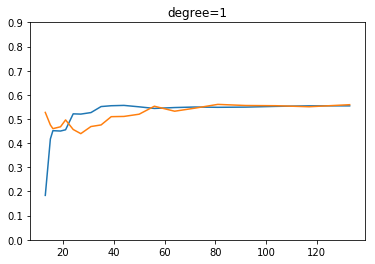

In [39]:
from sklearn.model_selection import learning_curve
model.set_params(polynomialfeatures__degree=1)
train_sizes, train_scores, validation_scores = learning_curve(
    model, x[:, np.newaxis], y, train_sizes=np.logspace(-1, 0, 20))

# Plot the mean train score and validation score across folds
plt.plot(train_sizes, validation_scores.mean(axis=1), label='cross-validation') 
plt.plot(train_sizes, train_scores.mean(axis=1), label='training') 
plt.title('degree=1')
plt.ylim(ymin=0,ymax=0.9)


Note that the validation score generally increases with a growing training set, while the training score generally decreases with a growing training set. As the training size increases, they will converge to a single value.

From the above discussion, we know that d = 1 is a high-bias estimator which under-fits the data. This is indicated by the fact that both the training and validation scores are low. When confronted with this type of learning curve, we can expect that adding more training data will not help: both lines converge to a relatively low score.

**When the learning curves have converged to a low score, we have a high bias model.**

A high-bias model can be improved by:

Using a more sophisticated model (i.e. in this case, increase d)
Gather more features for each sample.
Decrease regularization in a regularized model.
Increasing the number of samples, however, does not improve a high-bias model.

Now let’s look at a high-variance (i.e. over-fit) model:

/home/pbellec/env/nilearn/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


(0, 0.9)

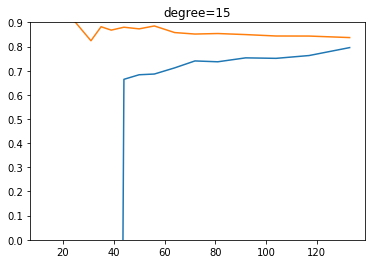

In [42]:
model.set_params(polynomialfeatures__degree=15)
train_sizes, train_scores, validation_scores = learning_curve(
    model, x[:, np.newaxis], y, train_sizes=np.logspace(-1, 0, 20))

# Plot the mean train score and validation score across folds
plt.plot(train_sizes, validation_scores.mean(axis=1), label='cross-validation') 

plt.plot(train_sizes, train_scores.mean(axis=1), label='training') 
plt.title('degree=15')
plt.ylim(ymin=0,ymax=0.9)

Here we show the learning curve for d = 15. From the above discussion, we know that d = 15 is a high-variance estimator which over-fits the data. This is indicated by the fact that the training score is much higher than the validation score. As we add more samples to this training set, the training score will continue to decrease, while the cross-validation error will continue to increase, until they meet in the middle.


**Learning curves that have not yet converged with the full training set indicate a high-variance, over-fit model.**

A high-variance model can be improved by:

Gathering more training samples.
Using a less-sophisticated model (i.e. in this case, make d smaller)
Increasing regularization.
In particular, gathering more features for each sample will not help the results.